## Imports
Below we import all required libraries for loading images, preprocessing,
building the CNN, and training it using PyTorch.


In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


## Load & Preprocess Images (Grayscale 128×128)
We load each image, convert it to grayscale, resize it to 128×128, normalize
pixel values to [0,1], and expand to shape (1,128,128) for CNN input.


In [5]:
IMG_SIZE = 128
base_path = "."
images_folder = os.path.join(base_path, "images")
csv_file = os.path.join(base_path, "legend.csv")

df = pd.read_csv(csv_file)

images = []
labels = []

print("Loading images...")

for idx, row in df.iterrows():
    img_name = row['image']
    emotion = row['emotion']
    
    img_path = os.path.join(images_folder, img_name)

    # Load in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Warning: could not load", img_path)
        continue
    
    # Resize for CNN
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Normalize to [0,1]
    img = img / 255.0
    
    # Add channel dimension → (1,128,128)
    img = np.expand_dims(img, axis=0)

    images.append(img)
    labels.append(emotion)

X = np.array(images, dtype=np.float32)
y = np.array(labels)

print("Finished loading images!")
print("X shape:", X.shape)   # Expected: (N, 1, 128, 128)
print("y shape:", y.shape)   # Expected: (N,)


Loading images...
Finished loading images!
X shape: (13690, 1, 128, 128)
y shape: (13690,)


## Label Encoding
We convert emotion labels (strings) into integer class IDs (0–6)
and store the mapping for later use.

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

num_classes = len(le.classes_)

print("Classes:", le.classes_)
print("Number of classes =", num_classes)
print("Sample encoded labels:", y_encoded[:10])

Classes: ['anger' 'contempt' 'disgust' 'fear' 'happiness' 'neutral' 'sadness'
 'suprise']
Number of classes = 8
Sample encoded labels: [0 7 2 3 5 4 5 4 4 4]


# Train / Validation / Test Split

We split the dataset into three parts:

- **70% Training**
- **15% Validation**
- **15% Testing**

We use *stratified sampling* to ensure that all 8 emotion classes maintain their proportions across the splits. This avoids issues where rare classes (e.g., *contempt*, *suprise*) disappear from validation or test sets.


In [7]:
from sklearn.model_selection import train_test_split

# 70% train, 30% temp split
X_tr, X_temp, y_tr, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.30,
    stratify=y_encoded,
    random_state=123
)

# Split temp 30% into 15% val + 15% test
X_val, X_te, y_val, y_te = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=123
)

print("Train:", X_tr.shape, "Labels:", y_tr.shape)
print("Val:  ", X_val.shape, "Labels:", y_val.shape)
print("Test: ", X_te.shape, "Labels:", y_te.shape)


Train: (9583, 1, 128, 128) Labels: (9583,)
Val:   (2053, 1, 128, 128) Labels: (2053,)
Test:  (2054, 1, 128, 128) Labels: (2054,)


# PyTorch Dataset and DataLoaders

To train a CNN efficiently, we convert our NumPy arrays into PyTorch tensors.
We create a custom `EmotionDataset` class that:

- Stores images and labels
- Converts them into PyTorch tensors
- Returns `(image, label)` pairs

We then wrap these in `DataLoader` objects to enable:

- Mini-batching
- Shuffling
- Fast loading during training


In [8]:
# Custom PyTorch Dataset for Emotion Images
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # shape: (N, 1, 128, 128)
        self.y = torch.tensor(y, dtype=torch.long)     # class IDs (0–7)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(EmotionDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(EmotionDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(EmotionDataset(X_te, y_te), batch_size=batch_size, shuffle=False)

# Quick sanity check
for images, labels in train_loader:
    print("Batch image shape:", images.shape)   # expected: (64, 1, 128, 128)
    print("Batch label shape:", labels.shape)   # expected: (64,)
    break


Batch image shape: torch.Size([64, 1, 128, 128])
Batch label shape: torch.Size([64])


# Define the EmotionCNN Model

We construct a deeper convolutional neural network suitable for 128×128
grayscale emotion images. The architecture includes:

- Three convolutional blocks (Conv → ReLU → MaxPool)
- Increasing filter sizes (32, 64, 128)
- Dropout for regularization
- Two fully connected layers
- Output layer with 8 logits corresponding to the 8 emotion classes

This model is significantly more expressive than the homework CNN and 
should perform better on complex visual emotion recognition tasks.


In [9]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()

        # ---- Convolutional Block 1 ----
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 → 64

        # ---- Convolutional Block 2 ----
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64 → 32

        # ---- Convolutional Block 3 ----
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32 → 16

        # ---- Fully Connected Layers ----
        # After 3 pools: 128 feature maps of size 16×16
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Block 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # logits

        return x


In [10]:
model = EmotionCNN(num_classes=num_classes)
print(model)


EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)


# Training the CNN

We now train the `EmotionCNN` model using:

- **CrossEntropyLoss** (standard for multi-class classification)
- **Adam optimizer**
- **Mini-batch training**
- **Training and validation accuracy tracking**

This section will also produce loss and accuracy curves to evaluate
underfitting vs overfitting.


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = EmotionCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Tracking
train_losses = []
val_losses = []
train_accs = []
val_accs = []

epochs = 15  # start with 15; you can increase later

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Training accuracy
        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = outputs.max(1)
            val_correct += (predicted == y_batch).sum().item()
            val_total += y_batch.size(0)
    
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Acc: {train_accs[-1]:.3f} | "
          f"Val Acc: {val_accs[-1]:.3f}")


Using device: cpu
Epoch 1/15 | Train Acc: 0.592 | Val Acc: 0.767
Epoch 2/15 | Train Acc: 0.732 | Val Acc: 0.749
Epoch 3/15 | Train Acc: 0.741 | Val Acc: 0.793
Epoch 4/15 | Train Acc: 0.769 | Val Acc: 0.804
Epoch 5/15 | Train Acc: 0.783 | Val Acc: 0.818
Epoch 6/15 | Train Acc: 0.793 | Val Acc: 0.817
Epoch 7/15 | Train Acc: 0.804 | Val Acc: 0.824
Epoch 8/15 | Train Acc: 0.811 | Val Acc: 0.818
Epoch 9/15 | Train Acc: 0.812 | Val Acc: 0.793
Epoch 10/15 | Train Acc: 0.822 | Val Acc: 0.832
Epoch 11/15 | Train Acc: 0.828 | Val Acc: 0.829
Epoch 12/15 | Train Acc: 0.827 | Val Acc: 0.833
Epoch 13/15 | Train Acc: 0.828 | Val Acc: 0.830
Epoch 14/15 | Train Acc: 0.833 | Val Acc: 0.814
Epoch 15/15 | Train Acc: 0.836 | Val Acc: 0.823


# Performance Curves and Test Evaluation

After training the CNN for 15 epochs, we visualize the model's learning
behavior by plotting:

- Training vs Validation Loss
- Training vs Validation Accuracy

These curves help diagnose underfitting or overfitting. Finally, we
evaluate the model on the held-out test set to obtain an unbiased estimate
of performance.


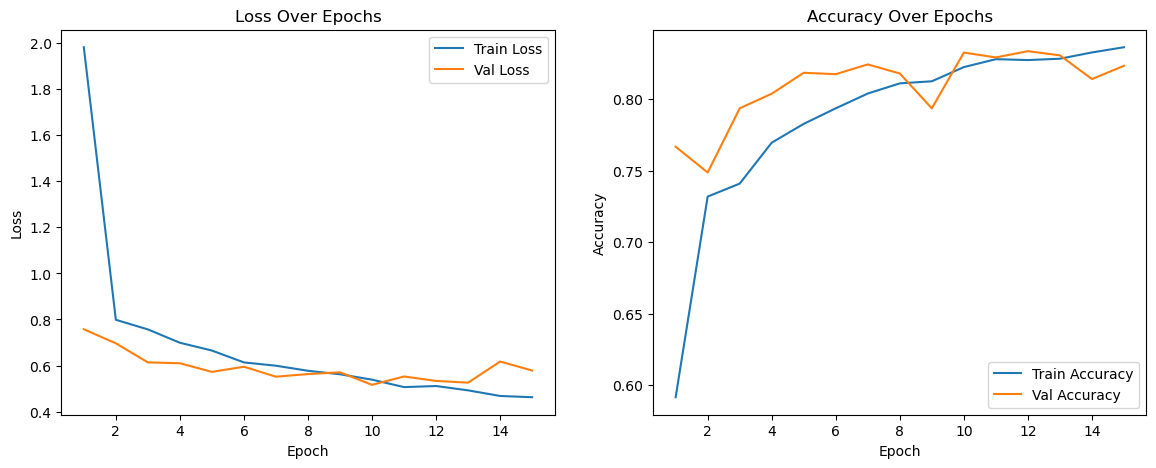

In [12]:
# Plot curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# ---- Loss Plot ----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# ---- Accuracy Plot ----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.plot(epochs_range, val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.show()


In [13]:
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = outputs.max(1)
        test_correct += (predicted == y_batch).sum().item()
        test_total += y_batch.size(0)

test_acc = test_correct / test_total
test_err = 1 - test_acc

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Error Rate: {test_err:.4f}")


Test Accuracy: 0.8199
Test Error Rate: 0.1801


# Confusion Matrix

To understand which emotions the model confuses, we compute a confusion
matrix over the test set. This helps visualize performance per class and
identify difficult emotion categories.


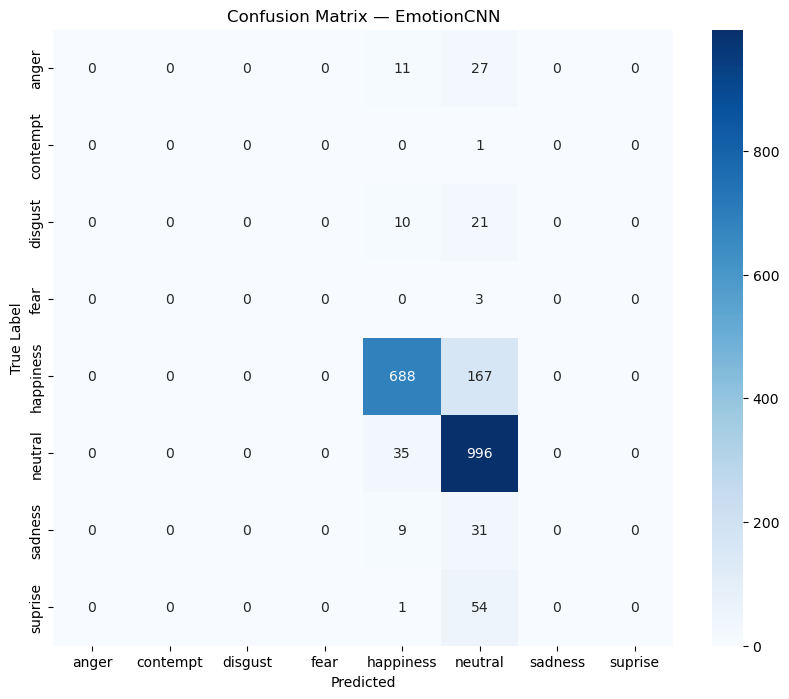

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix — EmotionCNN")
plt.show()
